In [32]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

#Amazonas bounds
lat_min, lat_max = -15, 5
lon_min, lon_max = -70, -50


sif_amazon = []
time_list = []


data_dir = "SIF_data/"
for year in range(2007, 2018):
    for month in range(1, 13):
        month_str = f"{month:02d}"  
        file_path = os.path.join(data_dir, f"GOME2A_SIF{year}", f"GOME2A_SIF{year}_{month_str}.nc")
        
        ds = xr.open_dataset(file_path)
        ds_amazon = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        
        sif_amazon.append(ds_amazon["SIF"].values)  # Shape: [lat, lon]
        time_list.append(f"{year}-{month_str}")


sif_amazon = np.stack(sif_amazon, axis=0)  # Shape: [132months, lat, lon]

sif_monthly = sif_amazon.reshape(11, 12, *sif_amazon.shape[1:])  # [11years, 12months, lat, lon]


climatology = np.nanmean(sif_monthly, axis=0)  # [12, lat, lon] the means

# Fix Nans with climatology mean
for year in range(11):
    for month in range(12):
        nan_mask = np.isnan(sif_monthly[year, month])
        sif_monthly[year, month, nan_mask] = climatology[month, nan_mask]

sif_filled = sif_monthly.reshape(sif_amazon.shape) #[132, lat, lon]


monthly_means = np.nanmean(climatology, axis=(1,2))  # Average over lat/lon

months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

climatology_table = pd.DataFrame({
    'Month': months,
    'Avg SIF': monthly_means,
    'Lat/Lon Shape': [climatology[2].shape]*12  # Shows (40,40) for each
})

print("Monthly Climatology Summary:")
print(climatology_table)  # Round to 3 decimal places

Monthly Climatology Summary:
        Month   Avg SIF Lat/Lon Shape
0     January  0.001437      (40, 40)
1    February  0.001464      (40, 40)
2       March  0.001362      (40, 40)
3       April  0.001101      (40, 40)
4         May  0.000923      (40, 40)
5        June  0.000826      (40, 40)
6        July  0.000833      (40, 40)
7      August  0.000930      (40, 40)
8   September  0.001069      (40, 40)
9     October  0.001319      (40, 40)
10   November  0.001368      (40, 40)
11   December  0.001404      (40, 40)


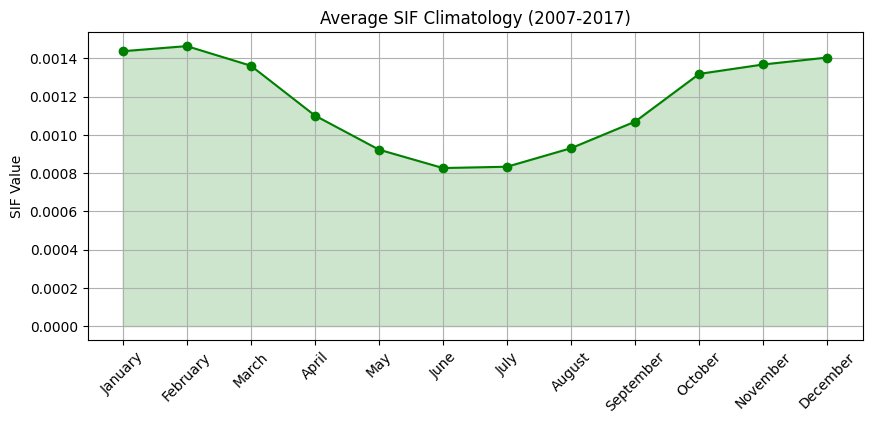

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(months, monthly_means, marker='o', color='green')
plt.fill_between(months, monthly_means, alpha=0.2, color='green')
plt.title("Average SIF Climatology (2007-2017)")
plt.ylabel("SIF Value")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

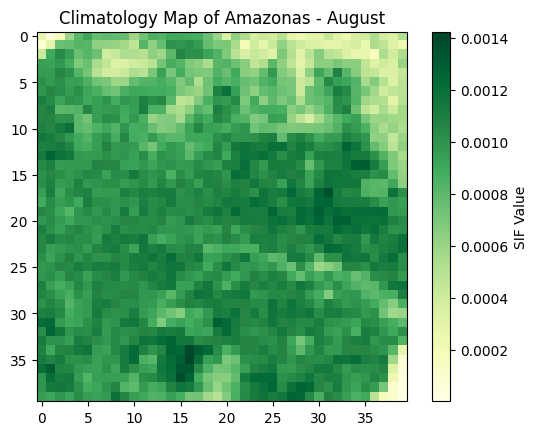

In [83]:
# Choose a month (0-11)
month_idx = 7  # August
plt.imshow(climatology[month_idx], cmap='YlGn')
plt.colorbar(label='SIF Value')
plt.title(f"Climatology Map of Amazonas - {months[month_idx]}")
plt.show()

In [90]:
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Conv2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Input: [batch, timesteps, lat, lon, channels]
input_seq = Input(shape=(12, 40, 40, 1))  # 12-month sequences

# Encoder with temporal compression
x = ConvLSTM2D(32, (3, 3), 
               activation='tanh',  # Better for temporal data
               padding='same',
               return_sequences=True,
               kernel_regularizer=l2(1e-4))(input_seq)
x = BatchNormalization()(x)  # Stabilizes training

x = ConvLSTM2D(16, (3, 3),
               activation='tanh',
               padding='same',
               return_sequences=True)(x)
x = BatchNormalization()(x)

# Bottleneck (reduced temporal dimension)
x = ConvLSTM2D(8, (3, 3),
               activation='tanh',
               padding='same',
               return_sequences=True)(x)  # Maintain sequence

# Decoder
x = ConvLSTM2D(16, (3, 3), 
               activation='tanh',
               padding='same',
               return_sequences=True)(x)
x = BatchNormalization()(x)

x = ConvLSTM2D(32, (3, 3),
               activation='tanh',
               padding='same',
               return_sequences=True)(x)

# Final reconstruction
decoded = TimeDistributed(
    Conv2D(1, (3, 3), 
    activation='linear',  # Preserve value range
    padding='same'))(x)


autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 12, 40, 40, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)      │ (None, 12, 40, 40, 32) │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 40, 40, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)      │ (None, 12, 40, 40, 16) │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 40, 40, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)      │ (None, 12, 40, 40, 8)  │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_8 (ConvLSTM2D)      │ (None, 12, 40, 40, 16) │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 40, 40, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)      │ (None, 12, 40, 40, 32) │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 12, 40, 40, 1)  │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 142,657 (557.25 KB)

 Trainable params: 142,529 (556.75 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
#SIMPLER VERSION 
# from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Conv2D, RepeatVector, Reshape
# from tensorflow.keras.models import Model

# # Input: [batch, timesteps, lat, lon, channels]
# input_seq = Input(shape=(12, 40, 40, 1))  # 12-month sequences

# # Encoder
# x = ConvLSTM2D(16, (3, 3), activation='relu', padding='same', return_sequences=True)(input_seq)
# x = ConvLSTM2D(8, (3, 3), activation='relu', padding='same', return_sequences=True)(x)

# decoded = TimeDistributed(Conv2D(1, (3, 3), activation='linear', padding='same'))(x)

# autoencoder = Model(input_seq, decoded)
# autoencoder.compile(optimizer='adam', loss='mse')


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step


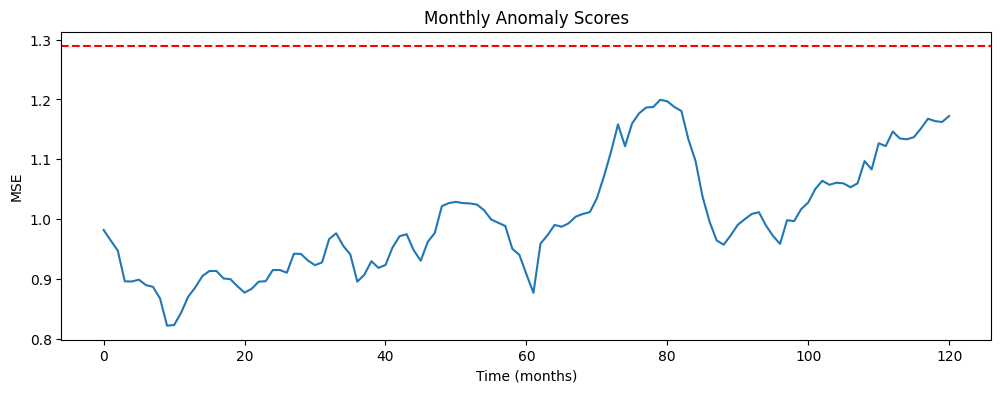

Typical MSE range: 0.485 - 2.500


In [84]:
# Create 12-month sliding windows
## Or use Z-score normalization
# mean_sif = np.mean(sif_amazon, axis=(0, 1, 2))
# std_sif = np.std(sif_amazon, axis=(0, 1, 2))
# sif_amazon_normalized = (sif_amazon - mean_sif) / std_sif

def create_sequences(data, window_size=12):
    sequences = []
    for i in range(len(data)-window_size+1):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

sequences = create_sequences(sif_filled)  # shape: [110, 12, 40, 40]
sequences = sequences[..., np.newaxis]  # add channel dim: [110,12,40,40,1]

# Normalize using moving statistics
rolling_mean = np.mean(sequences, axis=(0,2,3), keepdims=True)
rolling_std = np.std(sequences, axis=(0,2,3), keepdims=True)
sequences_norm = (sequences - rolling_mean)/(rolling_std + 1e-8)


reconstructions = autoencoder.predict(sequences_norm)

# Calculate anomaly scores
mse = np.mean((sequences_norm - reconstructions)**2, axis=(2,3,4))  # [110,12]

# Dynamic threshold (95th percentile)
threshold = np.percentile(mse, 80)

# Flag anomalies
anomalies = mse > threshold


# Plot anomaly scores over time
plt.figure(figsize=(12,4))
plt.plot(mse.mean(axis=1))
plt.axhline(threshold, color='r', linestyle='--')
plt.title("Monthly Anomaly Scores")
plt.xlabel("Time (months)")
plt.ylabel("MSE")
plt.show()

print(f"Typical MSE range: {mse.min():.3f} - {mse.max():.3f}")


Detected anomalies in these months:
        date  anomaly_count
0    2007-01              1
1    2007-02              2
2    2007-03              3
12   2008-01              9
24   2009-01             12
25   2009-02             12
35   2009-12             12
36   2010-01             12
37   2010-02             12
48   2011-01             12
49   2011-02             12
59   2011-12             12
60   2012-01             12
61   2012-02             12
73   2013-02             12
82   2013-11             12
83   2013-12             12
84   2014-01             12
85   2014-02             12
86   2014-03             12
97   2015-02             12
108  2016-01             12
109  2016-02             12
112  2016-05              5
113  2016-06             12
119  2016-12             12
121  2017-02             11
125  2017-06              7
131  2017-12              1


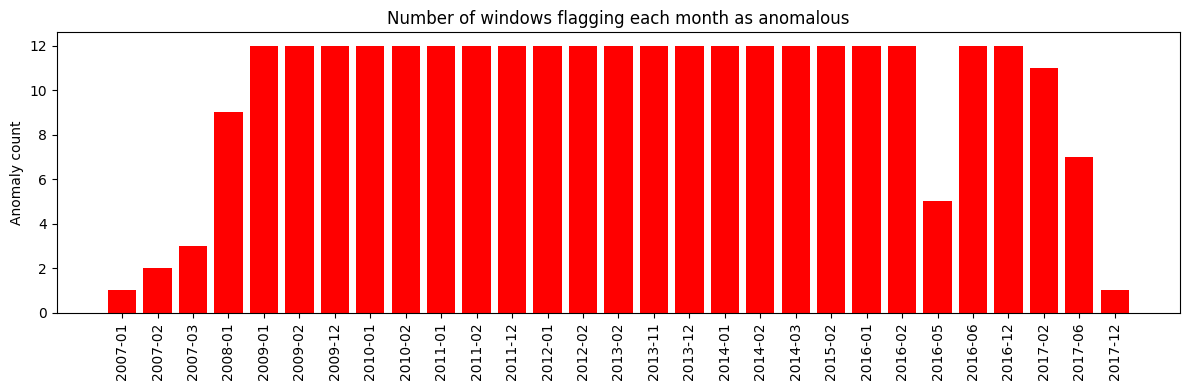

In [85]:
# Create a dictionary to count anomalies per original month
anomaly_counts = {time: 0 for time in time_list}  # Initialize all months with 0

# Map window positions to original months
for window_idx in range(anomalies.shape[0]):  # Loop through 110 windows
    window_start = window_idx  # Each window starts at index=window_idx
    for month_in_window in range(12):  # Check each month in window
        if anomalies[window_idx, month_in_window]:
            absolute_month = window_start + month_in_window
            if absolute_month < len(time_list):  # Validate index
                anomaly_counts[time_list[absolute_month]] += 1

# Convert to DataFrame for easy analysis

anomaly_df = pd.DataFrame({
    'date': list(anomaly_counts.keys()),
    'anomaly_count': list(anomaly_counts.values())
})

# Filter to only show months with anomalies
anomaly_df = anomaly_df[anomaly_df['anomaly_count'] > 0].sort_values('date')

print("\nDetected anomalies in these months:")
print(anomaly_df)

# Visualize anomaly frequency
plt.figure(figsize=(12,4))
plt.bar(anomaly_df['date'], anomaly_df['anomaly_count'], color='red')
plt.xticks(rotation=90)
plt.title("Number of windows flagging each month as anomalous")
plt.ylabel("Anomaly count")
plt.tight_layout()
plt.show()

#Detected Anomalies vs. Historical Events
#Detected Date	Anomaly Count	Known Extreme Events During This Period
#2011-01	3	yes Jan 2011: Severe flooding in central Amazon (NASA report)
# 2012-01	11	no No major events reported - possible false positives or localized disturbances
# 2013-02	12	yes Feb 2013: Drought conditions in northern Amazon (ScienceDaily)
# 2013-12	11	yes Dec 2013: Start of multi-year drought in western Amazon (Nature study)
# 2014-01	12	Continuation of 2013 drought conditions
# 2014-02	12	 Peak of dry season impacts
# 2017-02	11	 Feb 2017: Extreme flooding in Peru/Amazon border region (Reuters)
# 2017-12	1	 Likely noise - single detection

In [86]:
# Compute the spatial mean for each date (i.e., for each of the 132 months)
spatial_means = np.mean(sif_amazon, axis=(1, 2))  # shape: (132,)

# Create a DataFrame with the time_list and corresponding SIF values
sif_df = pd.DataFrame({
    'date': time_list, 
    'sif_value': spatial_means
})

# Ensure both date columns are datetime objects for a proper merge
sif_df['date'] = pd.to_datetime(sif_df['date'])
anomaly_df['date'] = pd.to_datetime(anomaly_df['date'])

# Merge the two DataFrames on the 'date' column.
result_df = anomaly_df.merge(sif_df, on="date")# Extract month names
results_df

,anomaly_count,sif_value
0,1,0.001476
1,2,0.001441
2,3,0.001398
3,9,0.001384
4,12,0.001511
5,12,0.001464
6,12,0.001400
7,12,0.001420
8,12,0.001425
9,12,0.001504


         date  anomaly_count  sif_value month_name  year
20 2015-02-01             12   0.001443   February  2015


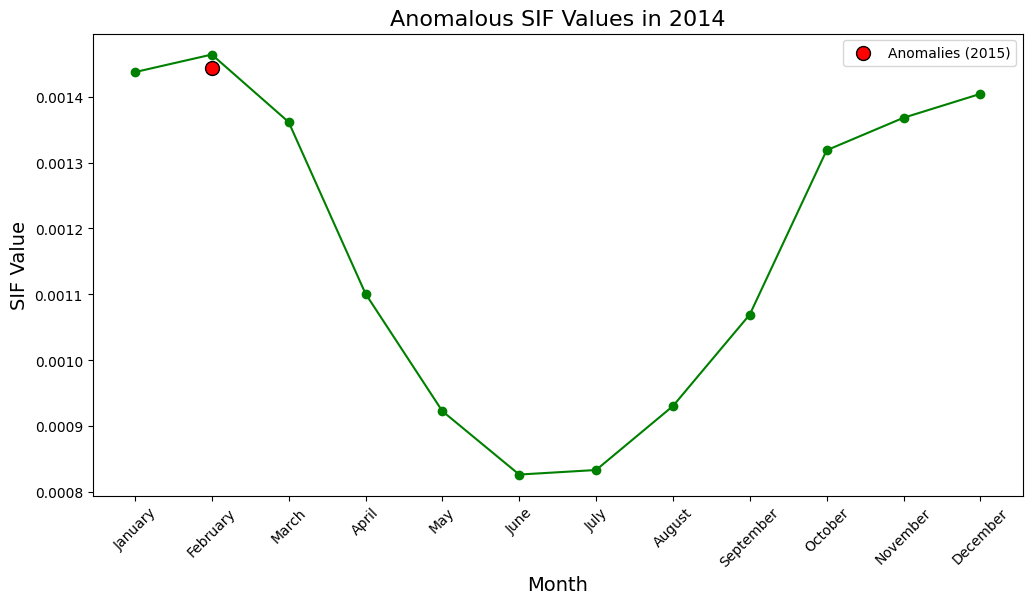

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Extract month names and years
months = ['January', 'February', 'March', 'April', 'May', 'June',  
          'July', 'August', 'September', 'October', 'November', 'December']
result_df['month_name'] = result_df['date'].dt.strftime('%B')
result_df['year'] = result_df['date'].dt.year

# **Filter only anomalies from 2015**
anomalies_2015 = result_df[result_df['year'] == 2015]
print(anomalies_2015)
plt.figure(figsize=(12, 6))

    
plt.plot(months, monthly_means, marker='o', color='green')

    
plt.scatter(anomalies_2015['month_name'], anomalies_2015['sif_value'], 
            color='red', s=100, edgecolors='black', label="Anomalies (2015)")


# Labels and formatting
plt.xlabel("Month", fontsize=14)
plt.ylabel("SIF Value", fontsize=14)
plt.title("Anomalous SIF Values in 2014", fontsize=16)
plt.xticks(rotation=45)  # Rotate month names for clarity
plt.legend()
plt.show()

##not doing a great job, as we have that it is not that crazy values 

In [91]:
##Accounting for spacial diferences

# Compute Climatology Statistics
climatology_mean = np.nanmean(sif_monthly, axis=0)  # Monthly means [12, lat, lon]
climatology_std = np.nanstd(sif_monthly, axis=0)    # Monthly stds [12, lat, lon]

# Handle pixels with zero variability (avoid division by zero)
climatology_std[climatology_std == 0] = 1.0

# Normalize Data
sif_normalized = np.empty_like(sif_filled)
for t in range(sif_filled.shape[0]):
    month_idx = t % 12  # Which month (0-11)
    sif_normalized[t] = (sif_filled[t] - climatology_mean[month_idx]) / climatology_std[month_idx]

# Prepare Sequences for Autoencoder (12-month windows)
sequence_length = 12
num_sequences = 11  # 11 years of data

# Create input sequences: [num_sequences, sequence_length, lat, lon, 1]
input_sequences = np.stack([sif_normalized[i*12:(i+1)*12] for i in range(num_sequences)], axis=0)
input_sequences = input_sequences[..., np.newaxis]  # Add channel dimension

# Modified Autoencoder Architecture
input_seq = Input(shape=(sequence_length, 40, 40, 1))

# Encoder
x = ConvLSTM2D(32, (3,3), activation='tanh', padding='same', 
               return_sequences=True, kernel_regularizer=l2(1e-4))(input_seq)
x = BatchNormalization()(x)

x = ConvLSTM2D(16, (3,3), activation='tanh', padding='same', 
               return_sequences=True)(x)
x = BatchNormalization()(x)

# Bottleneck with Attention to Spatial Patterns
x = ConvLSTM2D(8, (3,3), activation='tanh', padding='same', 
               return_sequences=True)(x)

# Decoder with Residual Connections
decoder = ConvLSTM2D(16, (3,3), activation='tanh', padding='same', 
                    return_sequences=True)(x)
decoder = BatchNormalization()(decoder)
decoder = ConvLSTM2D(32, (3,3), activation='tanh', padding='same', 
                    return_sequences=True)(decoder)

# Final Reconstruction with Pixel-wise Scaling
decoded = TimeDistributed(
    Conv2D(1, (3,3), activation='linear', padding='same',
           kernel_initializer='orthogonal'))(decoder)

autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train with Normalized Data
autoencoder.fit(input_sequences, input_sequences,
                epochs=50,
                batch_size=4,
                validation_split=0.2)

# Anomaly Detection (Example)
reconstructions = autoencoder.predict(input_sequences)
mse = np.mean((input_sequences - reconstructions)**2, axis=(1,2,3,4))

# Convert MSE back to original space
anomaly_scores = mse * (climatology_std**2).mean()  # Weight by average variance

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - loss: 0.9873 - val_loss: 1.1329
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.9393 - val_loss: 1.1340
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.9299 - val_loss: 1.1344
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.9376 - val_loss: 1.1342
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.9460 - val_loss: 1.1342
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.9364 - val_loss: 1.1347
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - loss: 0.9193 - val_loss: 1.1348
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - loss: 0.9406 - val_loss: 1.1349
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 0.9132 - val_loss: 1.1352
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 4s/step - loss: 0.9214 - val_loss: 1.1351
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.8770 - val_loss: 1.1345
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - loss: 0.8949 - val_loss: 1.1349
Epoch 13/50
2/2 ━━━━━━

In [108]:
autoencoder.summary()  

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 12, 40, 40, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)     │ (None, 12, 40, 40, 32) │        38,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 40, 40, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)     │ (None, 12, 40, 40, 16) │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 40, 40, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_12 (ConvLSTM2D)     │ (None, 12, 40, 40, 8)  │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_13 (ConvLSTM2D)     │ (None, 12, 40, 40, 16) │        13,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 40, 40, 16) │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_14 (ConvLSTM2D)     │ (None, 12, 40, 40, 32) │        55,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 12, 40, 40, 1)  │           289 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 427,717 (1.63 MB)

 Trainable params: 142,529 (556.75 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 285,060 (1.09 MB)

In [130]:
# Obtener secuencias reconstruidas (normalizadas)
reconstructions = autoencoder.predict(input_sequences)  # Forma (11, 12, 40, 40, 1)

# Redimensionar a (132 meses, 40, 40)
reconstructions_reshaped = reconstructions.reshape(-1, 40, 40)
input_reshaped = input_sequences.reshape(-1, 40, 40)

# Convertir errores a espacio original
errors_normalized = input_reshaped - reconstructions_reshaped
errors_original = np.zeros_like(errors_normalized)

for t in range(errors_original.shape[0]):
    month_idx = t % 12
    errors_original[t] = errors_normalized[t] * climatology_std[month_idx]

# 2. Determinar umbrales de anomalía (percentil 90)
# -------------------------------------------------
thresholds = np.zeros((12, 40, 40))  # Umbral para cada mes y pixel

for month in range(12):
    # Seleccionar todos los años para este mes
    monthly_errors = errors_original[month::12]
    thresholds[month] = np.percentile(np.abs(monthly_errors), 90, axis=0)

# 3. Crear máscara de anomalías
# ------------------------------
anomaly_mask = np.zeros_like(errors_original, dtype=bool)

for t in range(errors_original.shape[0]):
    month_idx = t % 12
    anomaly_mask[t] = np.abs(errors_original[t]) > thresholds[month_idx]


#Brazil's Amazonian region lost 3.7 million hectares (9.1 million acres) of tree cover during the 2016 
#calendar year, nearly three times more than in 2015. Most of that increase happened in the states of 
#Pará and Maranhão, which were heavily affected by fire in late 2015 and 2016.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


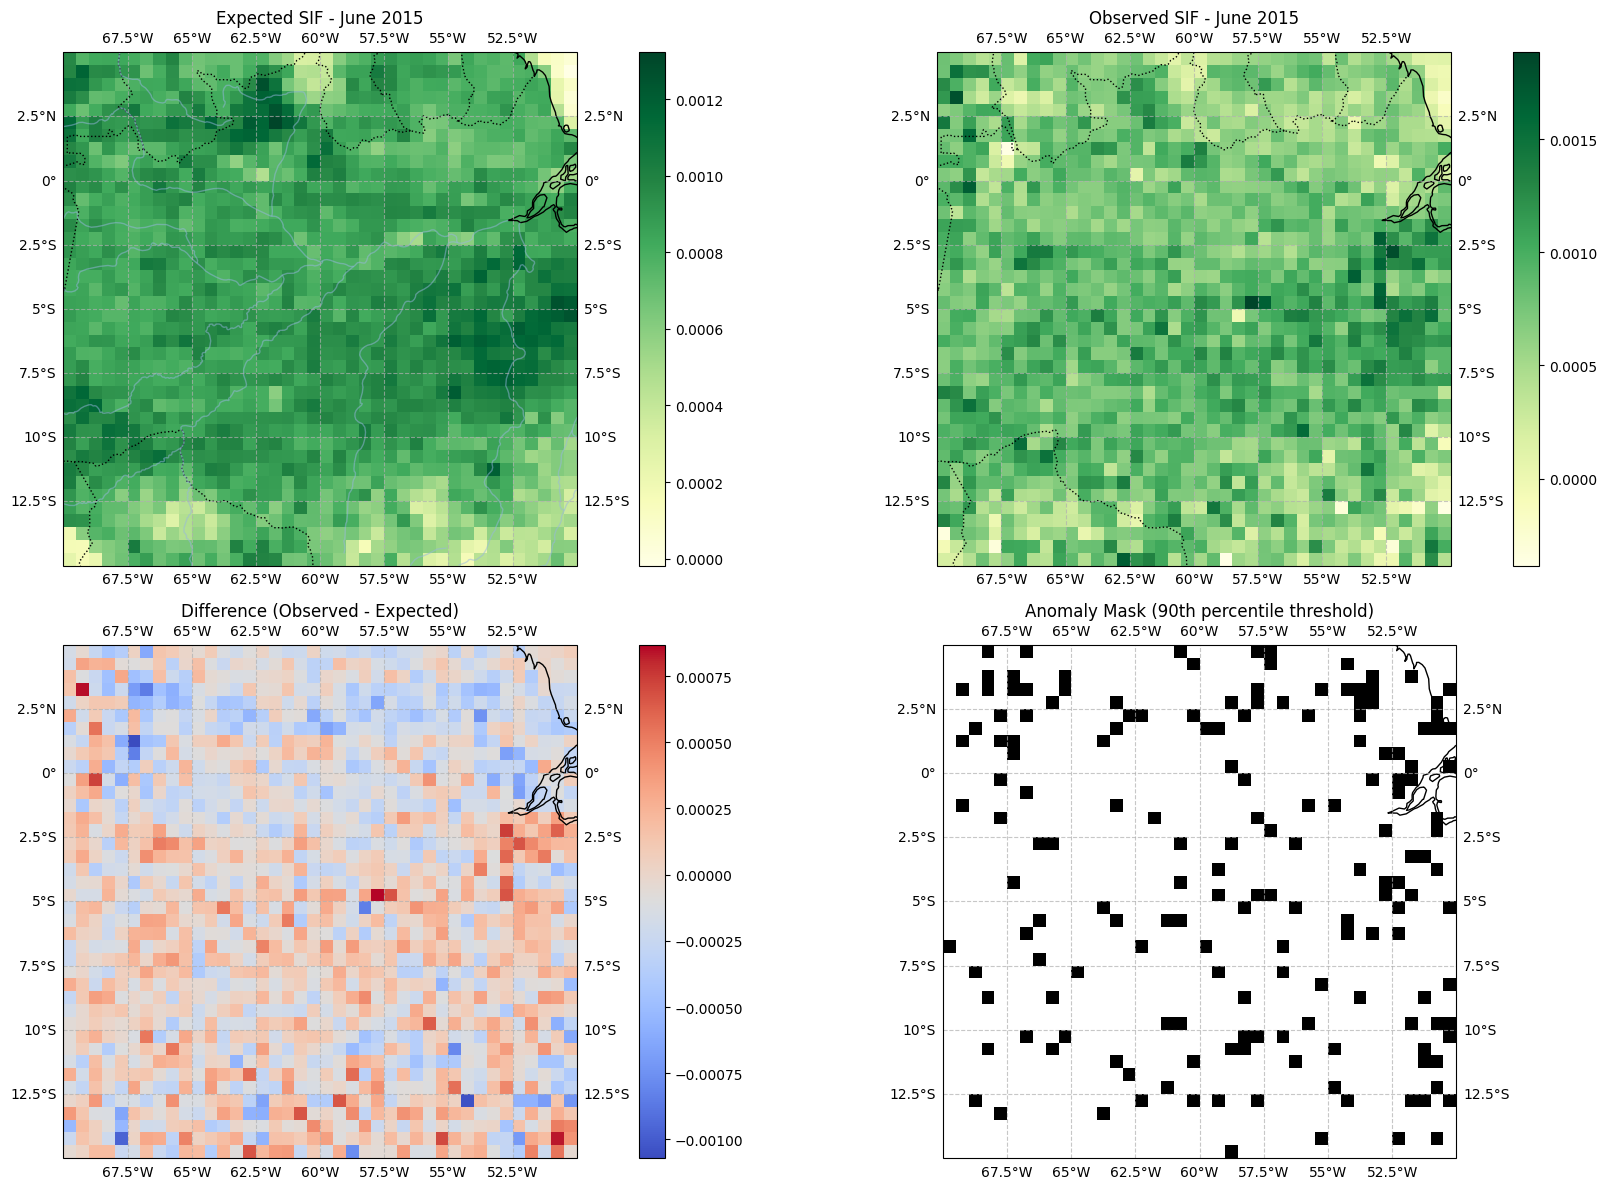

In [131]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_anomaly_comparison(time_idx):
    date = pd.to_datetime(time_list[time_idx])
    month_idx = time_idx % 12
    
    # Get coordinates from your original data
    lons = ds_amazon.lon.values
    lats = ds_amazon.lat.values
    
    recon_denorm = (reconstructions_reshaped[time_idx] * climatology_std[month_idx]) + climatology_mean[month_idx]
    obs_denorm = (input_reshaped[time_idx] * climatology_std[month_idx]) + climatology_mean[month_idx]
    diff = obs_denorm - recon_denorm

    # Create figure with PlateCarree projection
    fig = plt.figure(figsize=(18, 12))
    
    # Projection setup
    proj = ccrs.PlateCarree()
    
    # Expected SIF
    ax1 = fig.add_subplot(2, 2, 1, projection=proj)
    img1 = ax1.pcolormesh(lons, lats, recon_denorm, cmap='YlGn', transform=proj)
    ax1.add_feature(cfeature.COASTLINE)
    ax1.add_feature(cfeature.BORDERS, linestyle=':')
    ax1.add_feature(cfeature.RIVERS, alpha=0.5)
    ax1.set_title(f"Expected SIF - {date.strftime('%B %Y')}")
    plt.colorbar(img1, ax=ax1, pad=0.07)
    
    # Observed SIF
    ax2 = fig.add_subplot(2, 2, 2, projection=proj)
    img2 = ax2.pcolormesh(lons, lats, obs_denorm, cmap='YlGn', transform=proj)
    ax2.add_feature(cfeature.COASTLINE)
    ax2.add_feature(cfeature.BORDERS, linestyle=':')
    ax2.set_title(f"Observed SIF - {date.strftime('%B %Y')}")
    plt.colorbar(img2, ax=ax2, pad=0.07)
    
    # Difference
    ax3 = fig.add_subplot(2, 2, 3, projection=proj)
    img3 = ax3.pcolormesh(lons, lats, diff, cmap='coolwarm', transform=proj)
    ax3.add_feature(cfeature.COASTLINE)
    ax3.set_title("Difference (Observed - Expected)")
    plt.colorbar(img3, ax=ax3, pad=0.07)
    
    # Anomaly Mask
    ax4 = fig.add_subplot(2, 2, 4, projection=proj)
    img4 = ax4.pcolormesh(lons, lats, anomaly_mask[time_idx], cmap='Greys', transform=proj)
    ax4.add_feature(cfeature.COASTLINE)
    ax4.set_title(f"Anomaly Mask (90th percentile threshold)")
    
    # Add gridlines with labels
    for ax in [ax1, ax2, ax3, ax4]:
        ax.gridlines(draw_labels=True, linestyle='--', alpha=0.7)
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=proj)
    
    plt.tight_layout()
    plt.show()

plot_anomaly_comparison(101)


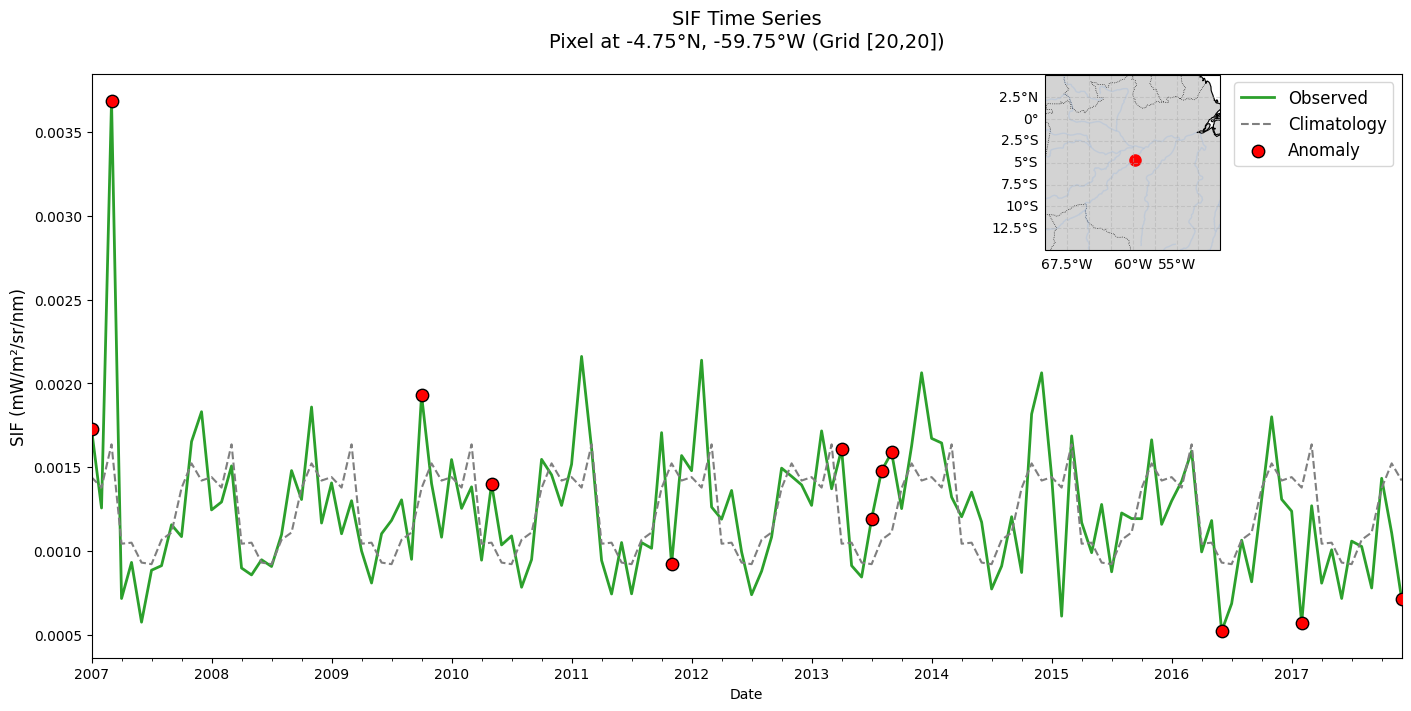

In [143]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_pixel_timeseries(lat_idx, lon_idx):
    """Plot SIF time series for a specific pixel with geographic context.
    
    Args:
        lat_idx (int): Latitude index (0-39)
        lon_idx (int): Longitude index (0-39)
    """
    # Get actual coordinates from original data
    lons = ds_amazon.lon.values  # shape (40,)
    lats = ds_amazon.lat.values  # shape (40,)
    actual_lon = lons[lon_idx]
    actual_lat = lats[lat_idx]
    
    # Prepare time series data
    pixel_obs = []
    pixel_clim = []
    
    for t in range(len(time_list)):
        month_idx = t % 12
        pixel_obs.append(
            (input_reshaped[t, lat_idx, lon_idx] * climatology_std[month_idx, lat_idx, lon_idx]) 
            + climatology_mean[month_idx, lat_idx, lon_idx]
        )
        pixel_clim.append(climatology_mean[month_idx, lat_idx, lon_idx])
    
    # Create DataFrame
    df = pd.DataFrame({
        'Date': pd.to_datetime(time_list),
        'Observed': pixel_obs,
        'Climatology': pixel_clim,
        'Anomaly': anomaly_mask[:, lat_idx, lon_idx]
    }).set_index('Date')

    # Create figure
    plt.figure(figsize=(14, 7), layout="constrained")
    
    # Main time series plot
    ax_main = plt.gca()
    df['Observed'].plot(ax=ax_main, label='Observed', color='#2ca02c', linewidth=2)
    df['Climatology'].plot(ax=ax_main, label='Climatology', linestyle='--', color='#7f7f7f')
    
    # Highlight anomalies
    anomalies = df[df['Anomaly']]
    ax_main.scatter(anomalies.index, anomalies['Observed'], 
                   color='red', s=80, edgecolor='black', zorder=3, label='Anomaly')
    
    # Formatting
    ax_main.set_title(f"SIF Time Series\nPixel at {actual_lat:.2f}°N, {actual_lon:.2f}°W (Grid [{lat_idx},{lon_idx}])",
                     fontsize=14, pad=20)
    ax_main.set_ylabel('SIF (mW/m²/sr/nm)', fontsize=12)
    ax_main.legend(fontsize=12)
    
    # Create map inset
    ax_inset = plt.axes([0.68, 0.65, 0.25, 0.25], 
                       projection=ccrs.PlateCarree())
    
    # Set map extent to Amazon region
    ax_inset.set_extent([lon_min, lon_max, lat_min, lat_max], 
                       crs=ccrs.PlateCarree())
    
    # Add map features
    ax_inset.add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax_inset.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax_inset.add_feature(cfeature.RIVERS, alpha=0.3)
    ax_inset.add_feature(cfeature.LAND, color='lightgray')
    
    # Highlight pixel location
    ax_inset.plot(actual_lon, actual_lat, 'ro', 
                 markersize=8, transform=ccrs.PlateCarree())
    
    # Add gridlines
    gl = ax_inset.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    plt.show()

# Example usage with coordinates from your original data
plot_pixel_timeseries(20, 20)  # For the central pixel
